In [ ]:
# Cell 1: Install Dependencies
# We use -q to keep the output clean
!pip install -q langgraph langchain langchain-groq langchain-huggingface langchain-chroma langchain-community duckduckgo-search sentence-transformers pydantic ddgs


print("✅ Dependencies installed successfully.")


✅ Dependencies installed successfully.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import getpass
import time
from typing import List, TypedDict


In [2]:
# Cell 2: Setup API Keys
if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API Key: ")

# Optional: Set a User Agent for Web Search to avoid 403 errors
os.environ["USER_AGENT"] = "VG-RAG-Researcher/1.0"

print("✅ Environment Configured.")


✅ Environment Configured.


In [3]:
# Cell 3: Initialize Vector DB
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.documents import Document

# 1. Define the Robust Dataset
from langchain_core.documents import Document

docs = [
    # ---------------------------------------------------------
    # GROUND TRUTH (The Anchor)
    # High reliability, precise wording.
    # ---------------------------------------------------------
    Document(
        page_content="The Commonwealth of Australia's capital city is Canberra. It was selected in 1908 as a compromise between the two largest cities.",
        metadata={"id": 1, "type": "truth", "reliability": "high"}
    ),
    Document(
        page_content="Following the federation of Australia in 1901, the search for a capital site commenced, eventually leading to the construction of Canberra.",
        metadata={"id": 2, "type": "truth", "reliability": "high"}
    ),

    # ---------------------------------------------------------
    # HARD NEGATIVES (The "Semantic" Trap)
    # These are factual statements containing keywords "Capital" and "Australia" 
    # but refer to State capitals or other concepts. 
    # Vector databases love retrieving these erroneously.
    # ---------------------------------------------------------
    Document(
        page_content="Sydney is the capital of New South Wales, Australia's most populous state, and serves as the nation's financial engine.",
        metadata={"id": 3, "type": "hard_negative", "reliability": "high"}
    ),
    Document(
        page_content="Melbourne is the capital of Victoria. It is often referred to as the 'cultural capital' of Australia due to its arts scene.",
        metadata={"id": 4, "type": "hard_negative", "reliability": "high"}
    ),
    Document(
        page_content="Perth is the capital of Western Australia, located on the opposite side of the continent from the federal capital.",
        metadata={"id": 5, "type": "hard_negative", "reliability": "high"}
    ),

    # ---------------------------------------------------------
    # TEMPORAL AMBIGUITY (The "History" Trap)
    # Facts that are technically true in a specific time window 
    # but false in the present context.
    # ---------------------------------------------------------
    Document(
        page_content="From 1901 until 1927, the Australian Parliament met in Melbourne, making it the de facto seat of government during that period.",
        metadata={"id": 6, "type": "temporal_ambiguity", "reliability": "medium"}
    ),
    Document(
        page_content="Before the new parliament house was opened in the late 20s, federal administration was largely conducted out of temporary offices in Victoria.",
        metadata={"id": 7, "type": "temporal_ambiguity", "reliability": "medium"}
    ),

    # ---------------------------------------------------------
    # SUBTLE HALLUCINATIONS (The "Precision" Trap)
    # 90% true, 10% false. These are harder to filter than obvious lies.
    # ---------------------------------------------------------
    Document(
        page_content="Canberra is the capital of Australia. It was officially founded in 1913, and the Parliament moved there permanently in 1950.", 
        # ERROR: Parliament moved in 1927, not 1950.
        metadata={"id": 8, "type": "subtle_hallucination", "reliability": "low"}
    ),
    Document(
        page_content="The capital of Australia is Canbera, a coastal city known for its naval base.", 
        # ERROR: Typos ("Canbera") and Geographically wrong (it is inland, not coastal).
        metadata={"id": 9, "type": "subtle_hallucination", "reliability": "low"}
    ),

    # ---------------------------------------------------------
    # CONFLICTING/UNCERTAIN INFO (The "Opinion" Trap)
    # Simulating forum posts or unofficial sources that introduce doubt.
    # ---------------------------------------------------------
    Document(
        page_content="Many tourists mistakenly believe Sydney is the capital because of the Opera House, but locals know the administrative power lies elsewhere.",
        metadata={"id": 10, "type": "uncertainty_discussion", "reliability": "low"}
    ),
    Document(
        page_content="There is an ongoing debate on a purely economic level that Sydney functions as the real capital, even if the maps say otherwise.",
        metadata={"id": 11, "type": "uncertainty_discussion", "reliability": "low"}
    ),

    # ---------------------------------------------------------
    # ADVERSARIAL NOISE (The "Distractor" Trap)
    # Irrelevant information that shares density/vocabulary with the target topic.
    # ---------------------------------------------------------
    Document(
        page_content="The Australian Capital Territory (ACT) is a federal district that imposes specific taxes on land ownership separate from NSW.",
        metadata={"id": 12, "type": "related_noise", "reliability": "high"}
    ),
    Document(
        page_content="Capital punishment was abolished in Australia in 1985 (NSW) and earlier in other states.", 
        # Shares the word "Capital" and "Australia" but totally different context.
        metadata={"id": 13, "type": "semantic_noise", "reliability": "high"}
    ),
    
    # ---------------------------------------------------------
    # NEW: PLAUSIBLE BUT UNVERIFIED (The "Rumor" Trap)
    # Designed to trigger UNCERTAIN (Score 0.40 - 0.75)
    # High Relevance (it answers the question directly)
    # Low Consistency/Agreement (it sounds like a rumor or unverified claim)
    # ---------------------------------------------------------
    Document(
        page_content="Some sources suggest that the capital of Australia might be moved to a new inland city called 'Wattle' by 2030 due to climate change concerns.",
        metadata={"id": 14, "type": "plausible_rumor", "reliability": "medium"}
    ),
    Document(
        page_content="While Canberra is the official capital, a recent (unconfirmed) report claims that executive power has quietly shifted back to Melbourne.",
        metadata={"id": 15, "type": "plausible_rumor", "reliability": "medium"}
    ),

    # ---------------------------------------------------------
    # HISTORICAL TRIVIA (The "Did You Know" Trap)
    # True facts that are relevant but might confuse the "current" status.
    # ---------------------------------------------------------
    Document(
        page_content="Dalgety was actually the first choice for the capital site in 1904, but the decision was later overturned in favor of Canberra.",
        metadata={"id": 16, "type": "historical_trivia", "reliability": "high"}
    ),

    # ---------------------------------------------------------
    # GEOGRAPHIC CONFUSION (The "Location" Trap)
    # Technically true geographic details that might look like contradictions.
    # ---------------------------------------------------------
    Document(
        page_content="Canberra is an enclave entirely surrounded by the state of New South Wales, leading some to incorrectly assume it is part of that state.",
        metadata={"id": 17, "type": "geographic_nuance", "reliability": "high"}
    ),
    
    # ---------------------------------------------------------
    # POPULAR CULTURE (The "Movie" Trap)
    # Fictional scenarios presented as text.
    # ---------------------------------------------------------
    Document(
        page_content="In the popular dystopian novel '2099', the capital of Australia has been relocated to Alice Springs to escape rising sea levels.",
        metadata={"id": 18, "type": "fiction", "reliability": "low"}
    ),

    # ---------------------------------------------------------
    # LEGAL TECHNICALITY (The "Loophole" Trap)
    # High relevance, low agreement.
    # ---------------------------------------------------------
    Document(
        page_content="The capital of Australia is often debated, with some constitutional experts arguing that the transfer of power to Canberra was never fully ratified.",
        metadata={"id": 19, "type": "legal_technicality", "reliability": "medium"}
    )
]

print("📥 Loading Embedding Model (This may take 30-60s on first run)...")
# Use a lightweight local model
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Create Vector Store
vectorstore = Chroma.from_documents(docs, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 10}) # Fetch Top 5 to ensure conflicts appear

print(f"✅ Vector DB Ready with {len(docs)} chunks.")


c:\Users\admin\Desktop\VG-RAG\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📥 Loading Embedding Model (This may take 30-60s on first run)...
✅ Vector DB Ready with 19 chunks.


In [4]:
# Cell 4: Define Graph State
class GraphState(TypedDict):
    """
    State of the VG-RAG graph.
    """
    question: str
    
    # Raw retrieved data
    retrieved_chunks: List[str]
    
    # Sorted buckets
    verified_chunks: List[str]
    uncertain_chunks: List[str]
    rejected_chunks: List[str]
    
    # Final output
    final_answer: str


In [5]:
# Cell 5: Define Nodes
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_community.tools import DuckDuckGoSearchRun
from pydantic import BaseModel, Field

# --- MODEL SETUP ---
# Use Llama-3-8b-Instant for speed
verifier_llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)
generator_llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)
web_search_tool = DuckDuckGoSearchRun()

# --- PYDANTIC SCHEMA ---
class VerificationResult(BaseModel):
    relevance: float = Field(description="Score 0.0 to 1.0: Does it answer the query?")
    consistency: float = Field(description="Score 0.0 to 1.0: Is it factually clear/consistent?")
    agreement: float = Field(description="Score 0.0 to 1.0: Does it align with other chunks?")
    reasoning: str = Field(description="Short reason for the score")

parser = JsonOutputParser(pydantic_object=VerificationResult)

# --- NODE 1: RETRIEVE ---
def retrieve(state: GraphState):
    print("\n--- 1. RETRIEVAL ---")
    question = state["question"]
    docs = retriever.invoke(question)
    chunks = [d.page_content for d in docs]
    print(f"   Fetched {len(chunks)} chunks.")
    return {"retrieved_chunks": chunks}

# --- NODE 2: VERIFICATION GATE ---
def verify_chunks(state: GraphState):
    print("\n--- 2. VERIFICATION GATE ---")
    question = state["question"]
    chunks = state["retrieved_chunks"]
    
    verified = []
    uncertain = []
    rejected = []
    
    # Prompt for the Verifier
    prompt = ChatPromptTemplate.from_template(
        """
        You are a strict RAG Verifier. Analyze the TARGET CHUNK.
        
        QUERY: {question}
        TARGET CHUNK: "{target}"
        CONTEXT (Other Retrieved Chunks):
        {context}
        
        Task:
        1. Relevance: Is the chunk relevant to the query?
        2. Consistency: Is the chunk clear and logical?
        3. Agreement: Does the chunk align with the CONTEXT? (If it contradicts the majority, score low).
        
        Output strictly valid JSON matching this format:
        {format_instructions}
        """
    )
    
    chain = prompt | verifier_llm | parser

    for chunk in chunks:
        try:
            # Exclude target from context for fair comparison
            other_chunks = [c for c in chunks if c != chunk]
            context_str = "\n".join(other_chunks)
            
            # Invoke LLM
            scores = chain.invoke({
                "question": question,
                "target": chunk,
                "context": context_str,
                "format_instructions": parser.get_format_instructions()
            })
            
            # Formula
            v_score = (0.5 * scores['relevance']) + (0.3 * scores['consistency']) + (0.2 * scores['agreement'])
            
            # --- CHANGE: Print FULL chunk text (No [:40]) ---
            print(f"   Chunk: \"{chunk}\"")
            print(f"   -> V-Score: {v_score:.2f}")
            
            if v_score >= 0.75:
                verified.append(chunk)
            elif v_score >= 0.40:
                uncertain.append(chunk)
            else:
                rejected.append(chunk)
                
        except Exception as e:
            print(f"   ⚠️ Error verifying chunk: {e}")
            rejected.append(chunk)
            
    return {
        "verified_chunks": verified,
        "uncertain_chunks": uncertain,
        "rejected_chunks": rejected
    }

# --- NODE 3: WEB SEARCH (SAFETY NET) ---
def web_search_check(state: GraphState):
    print("\n--- 3. SAFETY NET (WEB SEARCH) ---")
    uncertain = state["uncertain_chunks"]
    verified = state["verified_chunks"]
    
    if not uncertain:
        print("   No uncertain chunks to check.")
        return {"verified_chunks": verified}
    
    for chunk in uncertain:
        # --- CHANGE: Print FULL text ---
        print(f"   🔍 Verifying: \"{chunk}\"")
        try:
            # 1. Search
            search_query = f"Verify fact: {chunk}"
            results = web_search_tool.invoke(search_query)
            
            # --- CHANGE: Show exactly what the web found ---
            print(f"      📄 WEB FINDINGS: {results}")
            
            # 2. Check Entailment
            check_prompt = f"Fact: {chunk}\nWeb Evidence: {results}\nBased on the evidence, is the Fact TRUE? Answer 'YES' or 'NO' only."
            response = verifier_llm.invoke(check_prompt).content
            
            if "YES" in response.upper():
                print(f"      ✅ CONFIRMED by Web")
                verified.append(chunk)
            else:
                print(f"      ❌ REJECTED by Web")
        except Exception as e:
            print(f"      ⚠️ Search failed: {e}")
            
    return {"verified_chunks": verified, "uncertain_chunks": []}

# --- NODE 4: GENERATE ---
def generate(state: GraphState):
    print("\n--- 4. GENERATION ---")
    question = state["question"]
    
    # --- CHANGE: Structured Join with Source IDs ---
    formatted_chunks = []
    for i, chunk in enumerate(state["verified_chunks"]):
        formatted_chunks.append(f"SOURCE [{i+1}]: {chunk}")
    
    context = "\n\n".join(formatted_chunks)
    
    # --- CHANGE: Print exactly what goes to the Generator ---
    print(f"   📚 FINAL CONTEXT PASSED TO LLM:\n{'-'*30}\n{context}\n{'-'*30}")
    
    if not context:
        return {"final_answer": "I verified all retrieved information and found it to be unreliable or irrelevant. I cannot answer safely."}
        
    prompt = f"""
    Answer the question using ONLY the verified context below.
    Cite the SOURCE ID (e.g., [SOURCE 1]) for every fact you state.
    
    VERIFIED CONTEXT:
    {context}
    
    QUESTION: {question}
    """
    response = generator_llm.invoke(prompt)
    return {"final_answer": response.content}


In [6]:
# Cell 6: Construct Graph
from langgraph.graph import StateGraph, END

workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("verifier", verify_chunks)
workflow.add_node("web_search", web_search_check)
workflow.add_node("generate", generate)

# Add Edges
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "verifier")

# Conditional Logic
def route_step(state):
    if state["uncertain_chunks"]:
        return "web_search"
    else:
        return "generate"

workflow.add_conditional_edges(
    "verifier",
    route_step,
    {
        "web_search": "web_search",
        "generate": "generate"
    }
)

workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()
print("✅ LangGraph Compiled.")


✅ LangGraph Compiled.


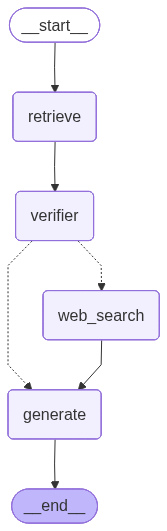

In [7]:
# Cell 7: Visualize
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    print("Graph Structure: Retrieve -> Verify -> (Condition) -> [Web Search or Generate] -> Generate")


In [8]:
result = app.invoke({"question": "Are there any plans to move the capital of Australia or shift power to Melbourne?"})
print("\n\nFINAL ANSWER:\n", result["final_answer"])



--- 1. RETRIEVAL ---
   Fetched 10 chunks.

--- 2. VERIFICATION GATE ---
   Chunk: "While Canberra is the official capital, a recent (unconfirmed) report claims that executive power has quietly shifted back to Melbourne."
   -> V-Score: 0.44
   Chunk: "Some sources suggest that the capital of Australia might be moved to a new inland city called 'Wattle' by 2030 due to climate change concerns."
   -> V-Score: 0.68
   Chunk: "There is an ongoing debate on a purely economic level that Sydney functions as the real capital, even if the maps say otherwise."
   -> V-Score: 0.53
   Chunk: "The Commonwealth of Australia's capital city is Canberra. It was selected in 1908 as a compromise between the two largest cities."
   -> V-Score: 0.82
   Chunk: "Canberra is the capital of Australia. It was officially founded in 1913, and the Parliament moved there permanently in 1950."
   -> V-Score: 0.55
   Chunk: "Melbourne is the capital of Victoria. It is often referred to as the 'cultural capital' of 